In [1]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:

# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=da13dd57-7781-4252-9416-f7758f8d9c4c
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:27<00:00, 52.9MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [6]:
import torch.nn.functional as F

class BAM(nn.Module):
    def __init__(self, channel, reduction=16, min_kernel_size=3):
        super(BAM, self).__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True)
        )
        self.min_kernel_size = min_kernel_size
        self.spatial_att = None  # We'll create this in the forward pass
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention
        channel_att = self.channel_att(x)

        # Adaptive spatial attention
        kernel_size = min(self.min_kernel_size, x.size(2) // 2, x.size(3) // 2)
        kernel_size = max(kernel_size, 1)  # Ensure kernel size is at least 1
        padding = kernel_size // 2

        if self.spatial_att is None or self.spatial_att[0].kernel_size[0] != kernel_size:
            self.spatial_att = nn.Sequential(
                nn.Conv2d(2, 1, kernel_size=kernel_size, stride=1, padding=padding, bias=False),
                nn.BatchNorm2d(1)
            ).to(x.device)

        spatial_att = self.spatial_att(torch.cat([
            torch.max(x, 1, keepdim=True)[0],
            torch.mean(x, 1, keepdim=True)
        ], dim=1))

        # Combine
        att = self.sigmoid(channel_att + spatial_att)
        return x * att

class ConvNeXtWithBAM(nn.Module):
    def __init__(self, num_classes=1000):
        super(ConvNeXtWithBAM, self).__init__()
        self.model = timm.create_model("hf_hub:timm/convnext_tiny.fb_in22k", pretrained=True)

        # Add BAM after each stage
        self.bam1 = BAM(96)
        self.bam2 = BAM(192)
        self.bam3 = BAM(384)
        self.bam4 = BAM(768)

        # Replace the final classification layer
        self.model.head.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.model.stem(x)

        x = self.model.stages[0](x)
        x = self.bam1(x)

        x = self.model.stages[1](x)
        x = self.bam2(x)

        x = self.model.stages[2](x)
        x = self.bam3(x)

        x = self.model.stages[3](x)
        x = self.bam4(x)

        x = self.model.head(x)
        return x


In [7]:

# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load data
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"

# Function to load dataset
def load_data(phase, data_dirs, data_root):
    data = []
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            data.append((image_path, label))
    return data

train_data = load_data('T4_Ptrain', data_dirs, data_root)
test_data = load_data('T4_Ptest', data_dirs, data_root)

# Split train data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Create datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Create the model
num_classes = len(data_dirs['T4_Ptrain'])
model = ConvNeXtWithBAM(num_classes=num_classes)


# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Move model to GPU
model.to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)

# Define loss function with class weights
class_counts = np.bincount([label for _, label in train_data])
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)






config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
# Train the model
num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler.step(val_loss)

# Save the trained model
torch.save(model.state_dict(), '/content/convnext_bam_model.pth')

Epoch 1/100, Train Loss: 0.8182, Train Accuracy: 57.46%, Val Loss: 0.8707, Val Accuracy: 65.13%


Epoch 2/100, Train Loss: 0.7068, Train Accuracy: 64.75%, Val Loss: 0.6508, Val Accuracy: 66.40%


Epoch 3/100, Train Loss: 0.5838, Train Accuracy: 71.25%, Val Loss: 0.6152, Val Accuracy: 68.95%


Epoch 4/100, Train Loss: 0.5137, Train Accuracy: 74.64%, Val Loss: 0.5282, Val Accuracy: 75.00%


Epoch 5/100, Train Loss: 0.4555, Train Accuracy: 78.11%, Val Loss: 0.6102, Val Accuracy: 74.20%


Epoch 6/100, Train Loss: 0.3866, Train Accuracy: 81.74%, Val Loss: 0.4348, Val Accuracy: 83.28%


Epoch 7/100, Train Loss: 0.3089, Train Accuracy: 86.68%, Val Loss: 0.4228, Val Accuracy: 81.53%


Epoch 8/100, Train Loss: 0.2498, Train Accuracy: 89.11%, Val Loss: 0.3855, Val Accuracy: 80.89%


Epoch 9/100, Train Loss: 0.2195, Train Accuracy: 89.95%, Val Loss: 0.4270, Val Accuracy: 85.67%


Epoch 10/100, Train Loss: 0.1683, Train Accuracy: 92.34%, Val Loss: 0.4031, Val Accuracy: 85.51%


Epoch 11/100, Train Loss: 0.1348, Train Accuracy: 94.38%, Val Loss: 0.4355, Val Accuracy: 87.42%


Epoch 12/100, Train Loss: 0.1584, Train Accuracy: 93.26%, Val Loss: 0.3768, Val Accuracy: 83.76%


Epoch 13/100, Train Loss: 0.1114, Train Accuracy: 95.26%, Val Loss: 0.4039, Val Accuracy: 85.19%


Epoch 14/100, Train Loss: 0.1024, Train Accuracy: 95.33%, Val Loss: 0.3917, Val Accuracy: 88.38%


Epoch 15/100, Train Loss: 0.0963, Train Accuracy: 95.93%, Val Loss: 0.4614, Val Accuracy: 87.58%


Epoch 16/100, Train Loss: 0.0982, Train Accuracy: 95.81%, Val Loss: 0.4472, Val Accuracy: 85.03%


Epoch 17/100, Train Loss: 0.0709, Train Accuracy: 96.93%, Val Loss: 0.4305, Val Accuracy: 86.94%


Epoch 18/100, Train Loss: 0.0397, Train Accuracy: 98.25%, Val Loss: 0.4713, Val Accuracy: 88.69%


Epoch 19/100, Train Loss: 0.0538, Train Accuracy: 97.65%, Val Loss: 0.4279, Val Accuracy: 87.74%


Epoch 20/100, Train Loss: 0.0812, Train Accuracy: 96.69%, Val Loss: 0.4291, Val Accuracy: 88.22%


Epoch 21/100, Train Loss: 0.0633, Train Accuracy: 97.25%, Val Loss: 0.4091, Val Accuracy: 90.92%


Epoch 22/100, Train Loss: 0.0339, Train Accuracy: 98.68%, Val Loss: 0.4542, Val Accuracy: 87.74%


Epoch 23/100, Train Loss: 0.0402, Train Accuracy: 98.56%, Val Loss: 0.5286, Val Accuracy: 88.54%


Epoch 24/100, Train Loss: 0.0254, Train Accuracy: 98.72%, Val Loss: 0.4390, Val Accuracy: 90.45%


Epoch 25/100, Train Loss: 0.0181, Train Accuracy: 99.32%, Val Loss: 0.4344, Val Accuracy: 90.92%


Epoch 26/100, Train Loss: 0.0142, Train Accuracy: 99.52%, Val Loss: 0.4307, Val Accuracy: 91.08%


Epoch 27/100, Train Loss: 0.0114, Train Accuracy: 99.64%, Val Loss: 0.4409, Val Accuracy: 91.08%


Epoch 28/100, Train Loss: 0.0110, Train Accuracy: 99.64%, Val Loss: 0.4349, Val Accuracy: 90.92%


Epoch 29/100, Train Loss: 0.0106, Train Accuracy: 99.60%, Val Loss: 0.4454, Val Accuracy: 90.92%


Epoch 30/100, Train Loss: 0.0102, Train Accuracy: 99.60%, Val Loss: 0.4434, Val Accuracy: 90.29%


Epoch 31/100, Train Loss: 0.0103, Train Accuracy: 99.56%, Val Loss: 0.4521, Val Accuracy: 90.13%


Epoch 32/100, Train Loss: 0.0088, Train Accuracy: 99.60%, Val Loss: 0.4541, Val Accuracy: 90.76%


Epoch 33/100, Train Loss: 0.0066, Train Accuracy: 99.84%, Val Loss: 0.4487, Val Accuracy: 90.29%


Epoch 34/100, Train Loss: 0.0071, Train Accuracy: 99.76%, Val Loss: 0.4517, Val Accuracy: 90.92%


Epoch 35/100, Train Loss: 0.0067, Train Accuracy: 99.72%, Val Loss: 0.4530, Val Accuracy: 91.08%


Epoch 36/100, Train Loss: 0.0073, Train Accuracy: 99.80%, Val Loss: 0.4540, Val Accuracy: 90.92%


Epoch 37/100, Train Loss: 0.0067, Train Accuracy: 99.80%, Val Loss: 0.4560, Val Accuracy: 90.92%


Epoch 38/100, Train Loss: 0.0072, Train Accuracy: 99.80%, Val Loss: 0.4564, Val Accuracy: 90.76%


Epoch 39/100, Train Loss: 0.0069, Train Accuracy: 99.68%, Val Loss: 0.4592, Val Accuracy: 90.92%


Epoch 40/100, Train Loss: 0.0058, Train Accuracy: 99.84%, Val Loss: 0.4600, Val Accuracy: 90.92%


Epoch 41/100, Train Loss: 0.0061, Train Accuracy: 99.80%, Val Loss: 0.4615, Val Accuracy: 91.08%


Epoch 42/100, Train Loss: 0.0072, Train Accuracy: 99.64%, Val Loss: 0.4627, Val Accuracy: 91.08%


Epoch 43/100, Train Loss: 0.0076, Train Accuracy: 99.72%, Val Loss: 0.4637, Val Accuracy: 90.92%


Epoch 44/100, Train Loss: 0.0067, Train Accuracy: 99.72%, Val Loss: 0.4636, Val Accuracy: 90.92%


Epoch 45/100, Train Loss: 0.0059, Train Accuracy: 99.92%, Val Loss: 0.4640, Val Accuracy: 91.08%


Epoch 46/100, Train Loss: 0.0058, Train Accuracy: 99.84%, Val Loss: 0.4657, Val Accuracy: 91.08%


Epoch 47/100, Train Loss: 0.0061, Train Accuracy: 99.84%, Val Loss: 0.4681, Val Accuracy: 91.08%


Epoch 48/100, Train Loss: 0.0068, Train Accuracy: 99.72%, Val Loss: 0.4710, Val Accuracy: 91.08%


Epoch 49/100, Train Loss: 0.0060, Train Accuracy: 99.88%, Val Loss: 0.4706, Val Accuracy: 90.92%


Epoch 50/100, Train Loss: 0.0071, Train Accuracy: 99.64%, Val Loss: 0.4716, Val Accuracy: 90.76%


Epoch 51/100, Train Loss: 0.0051, Train Accuracy: 99.76%, Val Loss: 0.4720, Val Accuracy: 91.08%


Epoch 52/100, Train Loss: 0.0075, Train Accuracy: 99.72%, Val Loss: 0.4742, Val Accuracy: 90.92%


Epoch 53/100, Train Loss: 0.0058, Train Accuracy: 99.84%, Val Loss: 0.4751, Val Accuracy: 90.92%


Epoch 54/100, Train Loss: 0.0050, Train Accuracy: 99.88%, Val Loss: 0.4746, Val Accuracy: 91.08%


Epoch 55/100, Train Loss: 0.0062, Train Accuracy: 99.80%, Val Loss: 0.4746, Val Accuracy: 90.92%


Epoch 56/100, Train Loss: 0.0064, Train Accuracy: 99.72%, Val Loss: 0.4755, Val Accuracy: 90.92%


Epoch 57/100, Train Loss: 0.0058, Train Accuracy: 99.88%, Val Loss: 0.4751, Val Accuracy: 90.61%


Epoch 58/100, Train Loss: 0.0064, Train Accuracy: 99.76%, Val Loss: 0.4754, Val Accuracy: 90.92%


Epoch 59/100, Train Loss: 0.0054, Train Accuracy: 99.80%, Val Loss: 0.4771, Val Accuracy: 90.76%


Epoch 60/100, Train Loss: 0.0052, Train Accuracy: 99.84%, Val Loss: 0.4791, Val Accuracy: 90.76%


Epoch 61/100, Train Loss: 0.0052, Train Accuracy: 99.76%, Val Loss: 0.4805, Val Accuracy: 90.92%


Epoch 62/100, Train Loss: 0.0053, Train Accuracy: 99.84%, Val Loss: 0.4801, Val Accuracy: 90.92%


Epoch 63/100, Train Loss: 0.0051, Train Accuracy: 99.84%, Val Loss: 0.4830, Val Accuracy: 90.61%


Epoch 64/100, Train Loss: 0.0057, Train Accuracy: 99.80%, Val Loss: 0.4825, Val Accuracy: 90.61%


Epoch 65/100, Train Loss: 0.0057, Train Accuracy: 99.88%, Val Loss: 0.4834, Val Accuracy: 90.92%


Epoch 66/100, Train Loss: 0.0049, Train Accuracy: 99.88%, Val Loss: 0.4843, Val Accuracy: 90.76%


Epoch 67/100, Train Loss: 0.0043, Train Accuracy: 99.84%, Val Loss: 0.4847, Val Accuracy: 90.61%


Epoch 68/100, Train Loss: 0.0048, Train Accuracy: 99.88%, Val Loss: 0.4859, Val Accuracy: 90.76%


Epoch 69/100, Train Loss: 0.0049, Train Accuracy: 99.80%, Val Loss: 0.4875, Val Accuracy: 90.76%


Epoch 70/100, Train Loss: 0.0048, Train Accuracy: 99.92%, Val Loss: 0.4871, Val Accuracy: 90.61%


Epoch 71/100, Train Loss: 0.0059, Train Accuracy: 99.76%, Val Loss: 0.4902, Val Accuracy: 90.76%


Epoch 72/100, Train Loss: 0.0053, Train Accuracy: 99.80%, Val Loss: 0.4895, Val Accuracy: 90.76%


Epoch 73/100, Train Loss: 0.0042, Train Accuracy: 99.84%, Val Loss: 0.4906, Val Accuracy: 90.76%


Epoch 74/100, Train Loss: 0.0035, Train Accuracy: 99.96%, Val Loss: 0.4913, Val Accuracy: 90.76%


Epoch 75/100, Train Loss: 0.0051, Train Accuracy: 99.88%, Val Loss: 0.4929, Val Accuracy: 90.92%


Epoch 76/100, Train Loss: 0.0036, Train Accuracy: 99.92%, Val Loss: 0.4937, Val Accuracy: 90.76%


Epoch 77/100, Train Loss: 0.0041, Train Accuracy: 99.88%, Val Loss: 0.4926, Val Accuracy: 90.76%


Epoch 78/100, Train Loss: 0.0050, Train Accuracy: 99.84%, Val Loss: 0.4951, Val Accuracy: 90.92%


Epoch 79/100, Train Loss: 0.0045, Train Accuracy: 99.88%, Val Loss: 0.4959, Val Accuracy: 90.92%


Epoch 80/100, Train Loss: 0.0043, Train Accuracy: 99.88%, Val Loss: 0.4980, Val Accuracy: 90.45%


Epoch 81/100, Train Loss: 0.0051, Train Accuracy: 99.80%, Val Loss: 0.5004, Val Accuracy: 90.61%


Epoch 82/100, Train Loss: 0.0047, Train Accuracy: 99.80%, Val Loss: 0.5027, Val Accuracy: 90.61%


Epoch 83/100, Train Loss: 0.0041, Train Accuracy: 99.92%, Val Loss: 0.5035, Val Accuracy: 90.61%


Epoch 84/100, Train Loss: 0.0043, Train Accuracy: 99.88%, Val Loss: 0.5049, Val Accuracy: 90.76%


Epoch 85/100, Train Loss: 0.0049, Train Accuracy: 99.68%, Val Loss: 0.5029, Val Accuracy: 90.61%


Epoch 86/100, Train Loss: 0.0034, Train Accuracy: 99.96%, Val Loss: 0.5021, Val Accuracy: 90.61%


Epoch 87/100, Train Loss: 0.0042, Train Accuracy: 99.88%, Val Loss: 0.5045, Val Accuracy: 90.61%


Epoch 88/100, Train Loss: 0.0042, Train Accuracy: 99.92%, Val Loss: 0.5018, Val Accuracy: 90.61%


Epoch 89/100, Train Loss: 0.0032, Train Accuracy: 99.96%, Val Loss: 0.5055, Val Accuracy: 90.76%


Epoch 90/100, Train Loss: 0.0046, Train Accuracy: 99.88%, Val Loss: 0.5073, Val Accuracy: 90.76%


Epoch 91/100, Train Loss: 0.0042, Train Accuracy: 99.84%, Val Loss: 0.5066, Val Accuracy: 90.92%


Epoch 92/100, Train Loss: 0.0026, Train Accuracy: 100.00%, Val Loss: 0.5065, Val Accuracy: 90.92%


Epoch 93/100, Train Loss: 0.0041, Train Accuracy: 99.88%, Val Loss: 0.5089, Val Accuracy: 90.92%


Epoch 94/100, Train Loss: 0.0033, Train Accuracy: 99.96%, Val Loss: 0.5092, Val Accuracy: 90.76%


Epoch 95/100, Train Loss: 0.0032, Train Accuracy: 99.92%, Val Loss: 0.5085, Val Accuracy: 90.76%


Epoch 96/100, Train Loss: 0.0041, Train Accuracy: 99.88%, Val Loss: 0.5123, Val Accuracy: 90.61%


Epoch 97/100, Train Loss: 0.0031, Train Accuracy: 99.96%, Val Loss: 0.5121, Val Accuracy: 90.29%


Epoch 98/100, Train Loss: 0.0032, Train Accuracy: 99.92%, Val Loss: 0.5138, Val Accuracy: 90.76%


Epoch 99/100, Train Loss: 0.0026, Train Accuracy: 99.96%, Val Loss: 0.5145, Val Accuracy: 90.76%


Epoch 100/100, Train Loss: 0.0033, Train Accuracy: 100.00%, Val Loss: 0.5175, Val Accuracy: 90.29%


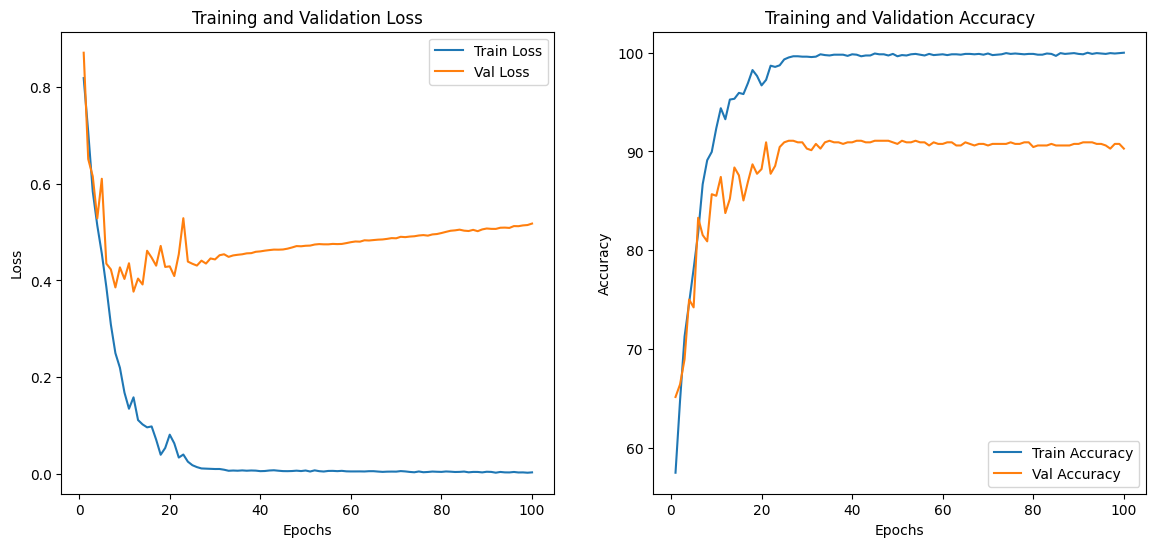

In [9]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [10]:
# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 91.39%
              precision    recall  f1-score   support

     Class 0       0.84      0.87      0.86       118
     Class 1       0.96      0.93      0.94       187
     Class 2       0.92      0.92      0.92       322

    accuracy                           0.91       627
   macro avg       0.91      0.91      0.91       627
weighted avg       0.91      0.91      0.91       627



In [11]:

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.87      0.86       118
     Class 1       0.96      0.93      0.94       187
     Class 2       0.92      0.92      0.92       322

    accuracy                           0.91       627
   macro avg       0.91      0.91      0.91       627
weighted avg       0.91      0.91      0.91       627

Confusion Matrix:
[[103   0  15]
 [  1 174  12]
 [ 18   8 296]]

Class-wise Metrics:
Class 0:
  TP: 103
  TN: 490
  FP: 19
  FN: 15
  Recall: 0.873
  Specificity: 0.963
  Precision: 0.844
  F1-score: 0.858
Class 1:
  TP: 174
  TN: 432
  FP: 8
  FN: 13
  Recall: 0.930
  Specificity: 0.982
  Precision: 0.956
  F1-score: 0.943
Class 2:
  TP: 296
  TN: 278
  FP: 27
  FN: 26
  Recall: 0.919
  Specificity: 0.911
  Precision: 0.916
  F1-score: 0.918

Macro-averaged Metrics:
Macro Recall: 0.908
Macro Precision: 0.906
Macro F1-score: 0.906
Accuracy (ACC): 0.914
Balanced Accuracy (BAC): 0.908
Custom